# Otimizando precificação

Esse projeto tem como objetivo melhorar uma plataforam digital de vendas de carro da Rusty Bargain. A plataforma deve **rapidamente aferir valor de mercado de um carro**. PAra isso, eu dados históricos dos carros vendidos na plataforma

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

## Preparação de Dados

### Impoortando bibliotecas e dados

In [1]:
### importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
### importando dados
df = pd.read_csv('/datasets/car_data.csv')

### Investigando os dados

In [3]:
### algumas linhas
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
### tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
### descrevendo distribuições
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Comentário**: A variável `NumberOfPictures` é nula!

In [6]:
### % dos dados faltantes
100*(df.isna().sum()/ df.shape[0])

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

**Comentário**: 
- A porcentagem de dados faltantes é considerável para `VehicleType` (10%) e `NotRepaired` (20%). Contudo, inferir ou substituir os dados faltantes dessas variáveis é difícil com base nas demais informações. Logo, eu vou optar por retirar as entradas com dados faltantes nessas duas variáveis. 

- As demais variáveis tem poucos dados faltantes que podem ser substituidos por medidas de centro ou nível mais comum.

In [7]:
### número de duplicadas
print('Número de entradas duplicadas: ', df.duplicated().sum())
print('Porcentagem de entradas duplicadas: ', 100*round((df.duplicated().sum()) / df.shape[0], 3) )

Número de entradas duplicadas:  262
Porcentagem de entradas duplicadas:  0.1


**Comentário**: Poucas entradas são duplicadas (menos de 0,1% dos dados), logo a retirada não terá muito impacto.

### Tratamento dos dados

In [8]:
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures', 'PostalCode', "LastSeen"], axis=1)

**Comentário**: Retirei um grupo de variáveis que não representam características do carro as ser vendido, mas sim características do post ou do comportamento do usuário que está vendendo o carro.

In [9]:
### retirando linhas com NAs
df.dropna(subset=['VehicleType', 'NotRepaired'], axis = 0, inplace=True)

**Comentário**: Retirei todas as entradas que não tinham dados faltantes para `VehicleType` e `NotRepaired`.

In [10]:
# definindo função para indicar nível mais comum de uma variável categórica
def common_level(x):
    level_counts = x.value_counts()
    boolean = (level_counts == max(level_counts))
    index = level_counts.index.values[boolean][0]
    return index

In [11]:
### substituindo NAs por categoria mais comum
df['Gearbox'].fillna(value = common_level(df['Gearbox']), inplace=True)
df["Model"].fillna(value = common_level(df['Model']), inplace=True)
df["FuelType"].fillna(value = common_level(df['FuelType']), inplace=True)

**Comentário**: Substitui os dados faltantes em `GearBox`, `Model` e `FuelType` pelas categorias mais comuns.

In [12]:
### checando dados faltantes
100*(df.isna().sum()/ df.shape[0])

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Mileage             0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64

In [13]:
### retirando dados duplicados
df.drop_duplicates(inplace=True)

In [14]:
### número de duplicadas
print('Número de entradas duplicadas: ', df.duplicated().sum())
print('Porcentagem de entradas duplicadas: ', 100*round((df.duplicated().sum()) / df.shape[0], 3) )

Número de entradas duplicadas:  0
Porcentagem de entradas duplicadas:  0.0


**Comentário**: Tratamento dos dados completo!

### Análise exploratória de dados

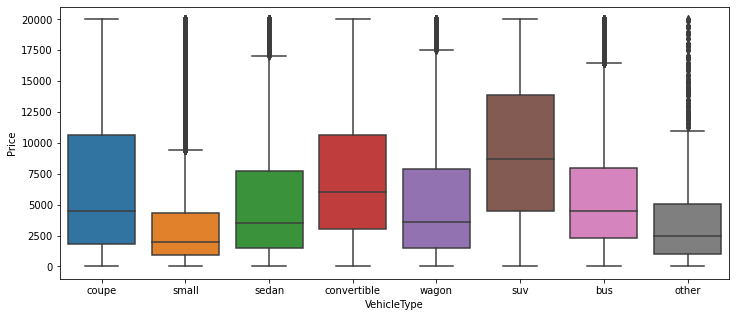

In [15]:
# Diagrama de caixa
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='VehicleType', y='Price')
plt.show()

**Comentário**: Tipo de veículo parece ter efeito no preço.

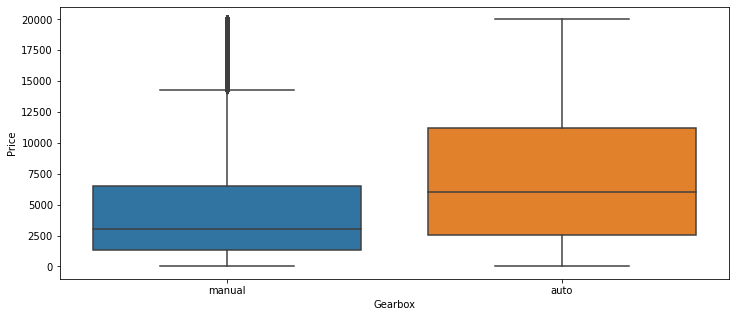

In [16]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='Gearbox', y='Price')
plt.show()

**Comentário**: Câmbio automático eleva o preço!

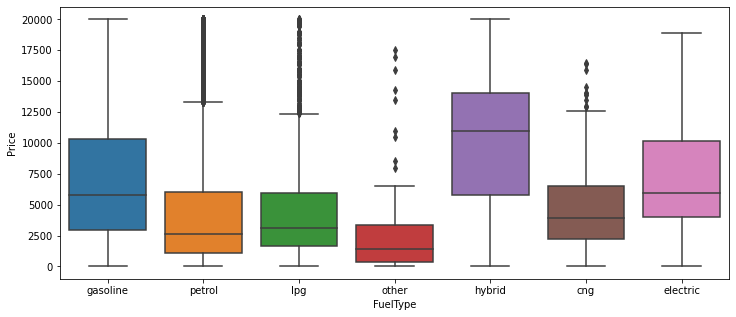

In [17]:
# Diagrama de caixa
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='FuelType', y='Price')
plt.show()

**Comentário**: Tipo de combustível tem efeito no preço.

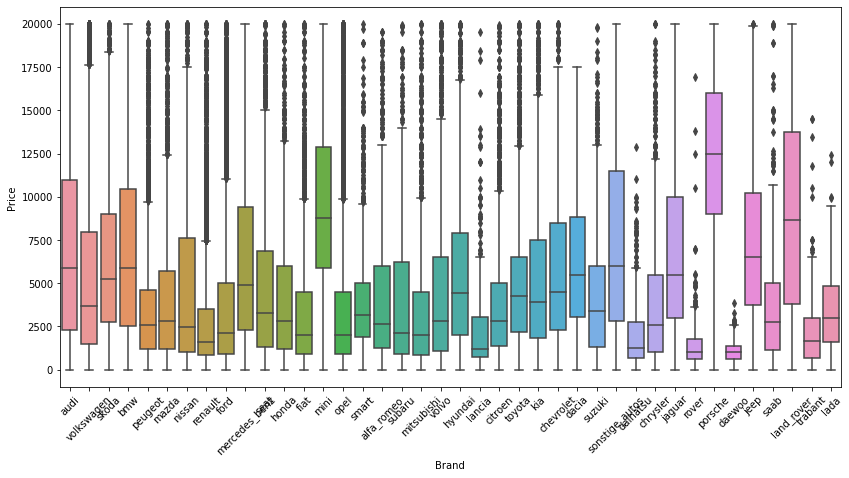

In [18]:
# Diagrama de caixa
plt.figure(figsize=(14,7))
sns.boxplot(data=df, x='Brand', y='Price')
plt.xticks(rotation=45)
plt.show()

**Comentário**: Existe também o efeito da fabricante sobre o preço!

In [19]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,golf,125000,gasoline,audi,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [20]:
## correlação entre variáveis contínuas
df[['Price', 'RegistrationYear', 'Power', 'Mileage']].corr()

,Price,RegistrationYear,Power,Mileage
Price,1.000000,0.503527,0.155319,-0.375088
RegistrationYear,0.503527,1.000000,0.051470,-0.289445
Power,0.155319,0.051470,1.000000,0.032392
Mileage,-0.375088,-0.289445,0.032392,1.000000


**Comentário**: O ano de registro e a kilometragem do carro prometem ser bons preditores do preço.

## Treinamento do modelo

### Preparando objetivo e características

In [21]:
target = df["Price"]
features = df.drop(["Price"], axis=1)

**Comentário**: O objetivo é o preço de anúncio do carro, e as características do carro são os preditores para esse preço.

In [22]:
### definindo função para padronizar variáveis
def standardize(df):
    df_std= (df-df.mean())/df.std()
    return df_std

In [23]:
### nome das características de valor contínuo
cont_feat_names = ['RegistrationYear', 'Power', 'Mileage']

In [24]:
### padronizando
features[cont_feat_names] = standardize(features[cont_feat_names])

**Comentário**: Padronizei as características com valor contínuo.

In [25]:
cat_feat_names = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired' ]

In [26]:
features = pd.get_dummies(features, columns= cat_feat_names)

**Comentário**: Transformei as variáveis categóricas em binárias.

### Partição de treino, validação e teste

In [27]:
### separando treino
feat_train, feat_vt, targ_train, targ_vt = train_test_split(features, target, train_size=0.6, random_state= 42)

In [28]:
### separando validação e teste
feat_valid, feat_test, targ_valid, targ_test = train_test_split(feat_vt, targ_vt, train_size=0.5, random_state= 42)

**Comentário**: Particionei os dados em 60% treino, 20% validação e 20% teste.

### Treinando modelos

In [29]:
### definindo função para ajuste de regressão linear
def set_regression_model(features_train, target_train, features_valid, target_valid):
    reg_model = LinearRegression()
    reg_model.fit(features_train, target_train)
    prediction = reg_model.predict(features_valid)
    rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
    print(f'Modelo de regressão - REQM: {round(rmse,2)}')
    return reg_model

In [30]:
### definindo função para ajuste de Random Forest
def set_forest_model(features_train, target_train, features_valid, target_valid, max_est, max_depth):
    best_forest_model = None
    best_est = 0
    best_depth = 0
    best_rmse =  float('inf')
    for est in range(1, max_est):
        for depth in range(1,max_depth):
            forest_model = RandomForestRegressor(n_estimators= est, max_depth= depth, random_state = 42)
            forest_model.fit(features_train, target_train)
            prediction = forest_model.predict(features_valid)
            ## avaliando
            rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
            if (rmse < best_rmse):
                best_forest_model = forest_model
                best_est = est
                best_depth = depth
                best_rmse = rmse
    print(f'Melhor floresta - número de árvores: {best_est}, profundidade: {best_depth}, REQM: {round(best_rmse,2)}')
    return best_forest_model

In [31]:
### definindo função para ajuste de Gradiente Boosting
def set_lgbm_model(features_train, target_train, features_valid, target_valid, n_estimators = 10, max_depth= 10, num_leaves = 30):
    best_lgbm_model = None
    best_est = 0
    best_depth = 0
    best_rmse =  float('inf')
    for est in range(1, n_estimators):
        for depth in range(1, max_depth):
            lgbm_model = LGBMRegressor(num_leaves = num_leaves, max_depth= depth, n_estimators = est, random_state=42)
            lgbm_model.fit(features_train, target_train)
            prediction = lgbm_model.predict(features_valid)
            rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
            if (rmse < best_rmse):
                best_lgbm_model = lgbm_model
                best_est = est
                best_depth = depth
                best_rmse = rmse
    print(f'Melhor LGBM - número de árvores: {best_est}, profundidade: {best_depth}, REQM: {round(best_rmse,2)}')
    return best_lgbm_model

In [39]:
%%timeit -r 1 -n 1
reg_model = set_regression_model(features_train = feat_train, target_train = targ_train, 
                                 features_valid= feat_valid, target_valid= targ_valid)

Modelo de regressão - REQM: 2871.96
11.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [49]:
%%timeit -r 1 -n 1
forest_model = set_forest_model(features_train = feat_train, target_train = targ_train, 
                                features_valid= feat_valid, target_valid= targ_valid,
                                max_est = 10, max_depth = 10)

Melhor floresta - número de árvores: 9, profundidade: 9, REQM: 2110.6
6min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
%%timeit -r 1 -n 1 
lgbm_model = set_lgbm_model(features_train = feat_train, target_train = targ_train, 
                            features_valid= feat_valid, target_valid= targ_valid, 
                            n_estimators = 10,  max_depth= 10, num_leaves =31)

Melhor LGBM - número de árvores: 9, profundidade: 9, REQM: 2838.92
2min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**Comentário**: Treinei três modelos distintos para prever o preço de venda do carro. Avaliei o poder preditivo dos modelos pelo REQM, e também considerei tempo necessário para treinar o modelo:
- Regressão linear: teve o menor poder preditivo, mas foi o mais rápido;
- Random forest: teve o melhor poder preditivo, mas foi o mais lento;
- Gradient Boosting com LGBM: teve poder preditivo e tempo de execução intermediários aos demais;

## Análise do modelo

In [42]:
def test_model(model, features_test, target_test):
    prediction = model.predict(features_test)
    rmse = np.sqrt( mean_squared_error(target_test, prediction) )
    return rmse

In [45]:
test_res1 = test_model(model = reg_model, features_test = feat_test, target_test = targ_test)
print(f'Teste da regressão linear, REQM: {round(test_res1,2)}')

Modelo de regressão, REQM: 30599330919.96


In [51]:
forest_model = set_forest_model(features_train = feat_train, target_train = targ_train, 
                                features_valid= feat_valid, target_valid= targ_valid,
                                max_est = 10, max_depth = 10)

test_res2 = test_model(model = forest_model, features_test = feat_test, target_test = targ_test)
print(f'Teste do Random Forest, REQM: {round(test_res2,2)}')

Melhor floresta - número de árvores: 9, profundidade: 9, REQM: 2110.6
Modelo de Random Forest, REQM: 2077.49


In [52]:
lgbm_model = set_lgbm_model(features_train = feat_train, target_train = targ_train, 
                            features_valid= feat_valid, target_valid= targ_valid, 
                            n_estimators = 10,  max_depth= 10, num_leaves =31)

test_res3 = test_model(model = lgbm_model, features_test = feat_test, target_test = targ_test)
print(f'Teste do LGBM, REQM: {round(test_res3,2)}')

Melhor LGBM - número de árvores: 9, profundidade: 9, REQM: 2838.92
Modelo de LGBM, REQM: 2815.34


# Conclusão

Nesse projeto, desenvolvi modelos para prever o preço de venda de carros que serão postados em um aplicativo. Para isso, treinei três modelos e avaliei os mesmos com base no seu poder predição e velocidade. O modelo que mostrou o melhor custo-benefício foi LGBM, que produziu predições razoáveis, mas 3 vezes mais rápidas que o modelo de melhor performance. 